In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).


Simple graph classification task
--------------------------------
In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![](https://data.dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
different types of graphs and each class has the same number of graph samples.



Using backend: pytorch


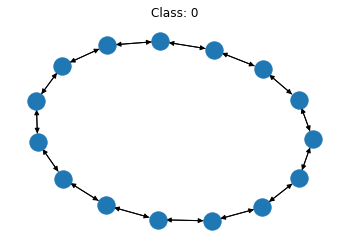

In [2]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

Form a graph mini-batch
-----------------------
To train neural networks efficiently, a common practice is to batch
multiple samples together to form a mini-batch. Batching fixed-shaped tensor
inputs is common. For example, batching two images of size 28 x 28
gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
has two challenges:

* Graphs are sparse.
* Graphs can have various length. For example, number of nodes and edges.

To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that
a batch of graphs can be viewed as a large graph that has many disjointed 
connected components. Below is a visualization that gives the general idea.

![](https://data.dgl.ai/tutorial/batch/batch.png)

    :width: 400pt
    :align: center

Define the following ``collate`` function to form a mini-batch from a given
list of graph and label pairs.



In [3]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph. In the same way, 
a batch of tensors is still a tensor. This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
because DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph classifier
----------------
Graph classification proceeds as follows.

![](https://data.dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, perform message passing and graph convolution
for nodes to communicate with others. After message passing, compute a
tensor for graph representation from node (and edge) attributes. This step might 
be called readout or aggregation. Finally, the graph 
representations are fed into a classifier $g$ to predict the graph labels.

Graph convolution layer can be found in the ``dgl.nn.<backend>`` submodule.



In [4]:
from dgl.nn.pytorch import GraphConv

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [6]:
from qplanarity import build_graph
dgl.from_networkx(build_graph([[0, 1], [2, 3]]))

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

In [8]:
from qplanarity import build_graph, generate_graphs, generate_graphs_dgl

trainset = list(zip(*generate_graphs_dgl(range(3, 11), 2 * [50] + 3 * [100] + 3 * [200], generator='binomial', verbose=True)))
testset = list(zip(*generate_graphs_dgl([16], [10])))

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  76.0% planar in average
Generated graphs with   6 nodes are at  69.0% planar in average
Generated graphs with   7 nodes are at  49.0% planar in average
Generated graphs with   8 nodes are at  58.0% planar in average
Generated graphs with   9 nodes are at  50.5% planar in average
Generated graphs with  10 nodes are at  48.5% planar in average
Generated graphs are at  60.8% planar in average


In [9]:
generate_graphs_dgl([10], [1000], generator='uniform_edges', verbose=True)
generate_graphs_dgl([10], [1000], generator='binomial', verbose=True)
0

0it [00:00, ?it/s]

Maximum edge number is 45
Generated graphs with  10 nodes are at  24.2% planar in average
Generated graphs are at  24.2% planar in average


0it [00:00, ?it/s]

Generated graphs with  10 nodes are at  49.7% planar in average
Generated graphs are at  49.7% planar in average


0

In [10]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
num_classes = 2
model = Classifier(1, 256, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 0.6409
Epoch 1, loss 0.4910
Epoch 2, loss 0.2318
Epoch 3, loss 0.1187
Epoch 4, loss 0.0896
Epoch 5, loss 0.0880
Epoch 6, loss 0.0817
Epoch 7, loss 0.0882
Epoch 8, loss 0.0789
Epoch 9, loss 0.0975
Epoch 10, loss 0.1084
Epoch 11, loss 0.0715
Epoch 12, loss 0.0692
Epoch 13, loss 0.0746
Epoch 14, loss 0.0747
Epoch 15, loss 0.0703
Epoch 16, loss 0.0676
Epoch 17, loss 0.0703
Epoch 18, loss 0.0750
Epoch 19, loss 0.0910
Epoch 20, loss 0.0991
Epoch 21, loss 0.0759
Epoch 22, loss 0.0697
Epoch 23, loss 0.0742
Epoch 24, loss 0.0739
Epoch 25, loss 0.0658
Epoch 26, loss 0.0700
Epoch 27, loss 0.0795
Epoch 28, loss 0.0816
Epoch 29, loss 0.0743
Epoch 30, loss 0.0752
Epoch 31, loss 0.0729
Epoch 32, loss 0.0672
Epoch 33, loss 0.0735
Epoch 34, loss 0.0876
Epoch 35, loss 0.0709
Epoch 36, loss 0.0715
Epoch 37, loss 0.0707
Epoch 38, loss 0.0780
Epoch 39, loss 0.0729
Epoch 40, loss 0.0748
Epoch 41, loss 0.0907
Epoch 42, loss 0.0758
Epoch 43, loss 0.0716
Epoch 44, loss 0.0716
Epoch 45, loss 0.086

The learning curve of a run is presented below.



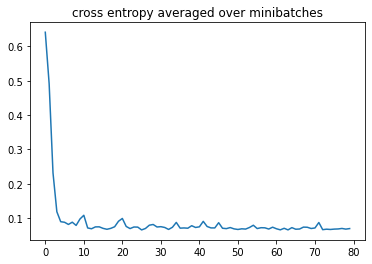

In [11]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [12]:
def dgl_tester(model, testset):
    model.eval()
    # Convert a list of tuples to two lists
    test_X, test_Y = map(list, zip(*testset))
    test_bg = dgl.batch(test_X)
    test_Y = torch.tensor(test_Y).float().view(-1, 1)
    probs_Y = torch.softmax(model(test_bg), 1)
    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
        (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
    argmax_score = (test_Y == argmax_Y.float()).sum().item() / len(test_Y)
    print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
        argmax_score * 100
    ))
    return argmax_Y, test_Y, argmax_score
dgl_tester(model, testset)[2]

Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%


1.0

In [17]:
from sklearn.metrics import confusion_matrix

scores = []
ns = range(3, 31)
for n in ns:
    graphs, targets = generate_graphs_dgl([n], [1000], generator='binomial', verbose=True)
    y_pred, y_true, score = dgl_tester(model, zip(graphs, targets))
    print(confusion_matrix(y_true, y_pred))
    print(f"\t### SCORE OF {score} FOR {n} NODES ###\n")
    scores.append(score)

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs are at 100.0% planar in average
Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%
[[1000]]
	### SCORE OF 1.0 FOR 3 NODES ###



0it [00:00, ?it/s]

Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs are at 100.0% planar in average
Accuracy of sampled predictions on the test set: 99.9000%
Accuracy of argmax predictions on the test set: 100.000000%
[[1000]]
	### SCORE OF 1.0 FOR 4 NODES ###



0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  78.9% planar in average
Generated graphs are at  78.9% planar in average
Accuracy of sampled predictions on the test set: 95.7000%
Accuracy of argmax predictions on the test set: 100.000000%
[[211   0]
 [  0 789]]
	### SCORE OF 1.0 FOR 5 NODES ###



0it [00:00, ?it/s]

Generated graphs with   6 nodes are at  66.2% planar in average
Generated graphs are at  66.2% planar in average
Accuracy of sampled predictions on the test set: 98.1000%
Accuracy of argmax predictions on the test set: 100.000000%
[[338   0]
 [  0 662]]
	### SCORE OF 1.0 FOR 6 NODES ###



0it [00:00, ?it/s]

Generated graphs with   7 nodes are at  49.5% planar in average
Generated graphs are at  49.5% planar in average
Accuracy of sampled predictions on the test set: 83.2000%
Accuracy of argmax predictions on the test set: 82.800000%
[[333 172]
 [  0 495]]
	### SCORE OF 0.828 FOR 7 NODES ###



0it [00:00, ?it/s]

Generated graphs with   8 nodes are at  53.4% planar in average
Generated graphs are at  53.4% planar in average
Accuracy of sampled predictions on the test set: 97.2000%
Accuracy of argmax predictions on the test set: 100.000000%
[[466   0]
 [  0 534]]
	### SCORE OF 1.0 FOR 8 NODES ###



0it [00:00, ?it/s]

Generated graphs with   9 nodes are at  55.4% planar in average
Generated graphs are at  55.4% planar in average
Accuracy of sampled predictions on the test set: 97.2000%
Accuracy of argmax predictions on the test set: 100.000000%
[[446   0]
 [  0 554]]
	### SCORE OF 1.0 FOR 9 NODES ###



0it [00:00, ?it/s]

Generated graphs with  10 nodes are at  49.3% planar in average
Generated graphs are at  49.3% planar in average
Accuracy of sampled predictions on the test set: 97.8000%
Accuracy of argmax predictions on the test set: 98.100000%
[[507   0]
 [ 19 474]]
	### SCORE OF 0.981 FOR 10 NODES ###



0it [00:00, ?it/s]

Generated graphs with  11 nodes are at  40.0% planar in average
Generated graphs are at  40.0% planar in average
Accuracy of sampled predictions on the test set: 96.8000%
Accuracy of argmax predictions on the test set: 97.200000%
[[572  28]
 [  0 400]]
	### SCORE OF 0.972 FOR 11 NODES ###



0it [00:00, ?it/s]

Generated graphs with  12 nodes are at  38.3% planar in average
Generated graphs are at  38.3% planar in average
Accuracy of sampled predictions on the test set: 97.1000%
Accuracy of argmax predictions on the test set: 97.500000%
[[592  25]
 [  0 383]]
	### SCORE OF 0.975 FOR 12 NODES ###



0it [00:00, ?it/s]

Generated graphs with  13 nodes are at  39.4% planar in average
Generated graphs are at  39.4% planar in average
Accuracy of sampled predictions on the test set: 96.2000%
Accuracy of argmax predictions on the test set: 96.700000%
[[573  33]
 [  0 394]]
	### SCORE OF 0.967 FOR 13 NODES ###



0it [00:00, ?it/s]

Generated graphs with  14 nodes are at  29.9% planar in average
Generated graphs are at  29.9% planar in average
Accuracy of sampled predictions on the test set: 89.1000%
Accuracy of argmax predictions on the test set: 88.700000%
[[588 113]
 [  0 299]]
	### SCORE OF 0.887 FOR 14 NODES ###



0it [00:00, ?it/s]

Generated graphs with  15 nodes are at  35.1% planar in average
Generated graphs are at  35.1% planar in average
Accuracy of sampled predictions on the test set: 94.2000%
Accuracy of argmax predictions on the test set: 98.400000%
[[633  16]
 [  0 351]]
	### SCORE OF 0.984 FOR 15 NODES ###



0it [00:00, ?it/s]

Generated graphs with  16 nodes are at  23.5% planar in average
Generated graphs are at  23.5% planar in average
Accuracy of sampled predictions on the test set: 86.5000%
Accuracy of argmax predictions on the test set: 89.100000%
[[656 109]
 [  0 235]]
	### SCORE OF 0.891 FOR 16 NODES ###



0it [00:00, ?it/s]

Generated graphs with  17 nodes are at  20.3% planar in average
Generated graphs are at  20.3% planar in average
Accuracy of sampled predictions on the test set: 96.3000%
Accuracy of argmax predictions on the test set: 97.000000%
[[767  30]
 [  0 203]]
	### SCORE OF 0.97 FOR 17 NODES ###



0it [00:00, ?it/s]

Generated graphs with  18 nodes are at  21.4% planar in average
Generated graphs are at  21.4% planar in average
Accuracy of sampled predictions on the test set: 97.3000%
Accuracy of argmax predictions on the test set: 97.900000%
[[765  21]
 [  0 214]]
	### SCORE OF 0.979 FOR 18 NODES ###



0it [00:00, ?it/s]

Generated graphs with  19 nodes are at  19.8% planar in average
Generated graphs are at  19.8% planar in average
Accuracy of sampled predictions on the test set: 97.5000%
Accuracy of argmax predictions on the test set: 96.900000%
[[771  31]
 [  0 198]]
	### SCORE OF 0.969 FOR 19 NODES ###



0it [00:00, ?it/s]

Generated graphs with  20 nodes are at  18.3% planar in average
Generated graphs are at  18.3% planar in average
Accuracy of sampled predictions on the test set: 99.3000%
Accuracy of argmax predictions on the test set: 100.000000%
[[817   0]
 [  0 183]]
	### SCORE OF 1.0 FOR 20 NODES ###



0it [00:00, ?it/s]

Generated graphs with  21 nodes are at  15.1% planar in average
Generated graphs are at  15.1% planar in average
Accuracy of sampled predictions on the test set: 94.1000%
Accuracy of argmax predictions on the test set: 93.400000%
[[783  66]
 [  0 151]]
	### SCORE OF 0.934 FOR 21 NODES ###



0it [00:00, ?it/s]

Generated graphs with  22 nodes are at  11.6% planar in average
Generated graphs are at  11.6% planar in average
Accuracy of sampled predictions on the test set: 94.5000%
Accuracy of argmax predictions on the test set: 94.200000%
[[826  58]
 [  0 116]]
	### SCORE OF 0.942 FOR 22 NODES ###



0it [00:00, ?it/s]

Generated graphs with  23 nodes are at   9.4% planar in average
Generated graphs are at   9.4% planar in average
Accuracy of sampled predictions on the test set: 95.0000%
Accuracy of argmax predictions on the test set: 94.500000%
[[851  55]
 [  0  94]]
	### SCORE OF 0.945 FOR 23 NODES ###



0it [00:00, ?it/s]

Generated graphs with  24 nodes are at  10.7% planar in average
Generated graphs are at  10.7% planar in average
Accuracy of sampled predictions on the test set: 94.3000%
Accuracy of argmax predictions on the test set: 93.500000%
[[828  65]
 [  0 107]]
	### SCORE OF 0.935 FOR 24 NODES ###



0it [00:00, ?it/s]

Generated graphs with  25 nodes are at   7.4% planar in average
Generated graphs are at   7.4% planar in average
Accuracy of sampled predictions on the test set: 92.5000%
Accuracy of argmax predictions on the test set: 92.200000%
[[848  78]
 [  0  74]]
	### SCORE OF 0.922 FOR 25 NODES ###



0it [00:00, ?it/s]

Generated graphs with  26 nodes are at   9.5% planar in average
Generated graphs are at   9.5% planar in average
Accuracy of sampled predictions on the test set: 94.7000%
Accuracy of argmax predictions on the test set: 94.500000%
[[850  55]
 [  0  95]]
	### SCORE OF 0.945 FOR 26 NODES ###



0it [00:00, ?it/s]

Generated graphs with  27 nodes are at   6.6% planar in average
Generated graphs are at   6.6% planar in average
Accuracy of sampled predictions on the test set: 93.1000%
Accuracy of argmax predictions on the test set: 92.000000%
[[854  80]
 [  0  66]]
	### SCORE OF 0.92 FOR 27 NODES ###



0it [00:00, ?it/s]

Generated graphs with  28 nodes are at   7.8% planar in average
Generated graphs are at   7.8% planar in average
Accuracy of sampled predictions on the test set: 96.0000%
Accuracy of argmax predictions on the test set: 95.500000%
[[877  45]
 [  0  78]]
	### SCORE OF 0.955 FOR 28 NODES ###



0it [00:00, ?it/s]

Generated graphs with  29 nodes are at   6.6% planar in average
Generated graphs are at   6.6% planar in average
Accuracy of sampled predictions on the test set: 94.2000%
Accuracy of argmax predictions on the test set: 94.700000%
[[881  53]
 [  0  66]]
	### SCORE OF 0.947 FOR 29 NODES ###



0it [00:00, ?it/s]

Generated graphs with  30 nodes are at   5.3% planar in average
Generated graphs are at   5.3% planar in average
Accuracy of sampled predictions on the test set: 95.2000%
Accuracy of argmax predictions on the test set: 95.700000%
[[904  43]
 [  0  53]]
	### SCORE OF 0.957 FOR 30 NODES ###



In [ ]:
plt.plot(ns, scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of nodes')

The animation here plots the probability that a trained model predicts the correct graph type.

![](https://data.dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node and graph representations that a trained model learned,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://data.dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://data.dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after one and two
layers of graph convolution. The figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
you would not expect a perfect result. Node degrees are deterministic for
these node features. The graph features are improved when separated.

What's next?
------------
Graph classification with graph neural networks is still a new field.
It's waiting for people to bring more exciting discoveries. The work requires 
mapping different graphs to different embeddings, while preserving
their structural similarity in the embedding space. To learn more about it, see 
`How Powerful Are Graph Neural Networks? <https://arxiv.org/abs/1810.00826>`_ a research paper  
published for the International Conference on Learning Representations 2019.

For more examples about batched graph processing, see the following:

* Tutorials for `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* An example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_




	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average

	# 2. Train model

Epoch 0, loss 0.6538
Epoch 1, loss 0.5023
Epoch 2, loss 0.2324
Epoch 3, loss 0.1219
Epoch 4, loss 0.1048
Epoch 5, loss 0.0819
Epoch 6, loss 0.0746
Epoch 7, loss 0.0693
Epoch 8, loss 0.0782
Epoch 9, loss 0.0715
Epoch 10, loss 0.0872
Epoch 11, loss 0.0674
Epoch 12, loss 0.0658
Epoch 13, loss 0.0757
Epoch 14, loss 0.0873
Epoch 15, loss 0.0630
Epoch 16, loss 0.0678
Epoch 17, loss 0.0717
Epoch 18, loss 0.0762
Epoch 19, l

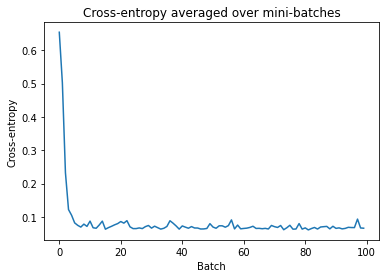

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=2, bias=True)
)

	# 3. Smoke-test model

Accuracy of sampled predictions on the test set: 95.9000%
Accuracy of argmax predictions on the test set: 97.200000%
[[368  18]
 [ 10 604]]
              precision    recall  f1-score   support

  Non-planar       0.97      0.95      0.96       386
      Planar       0.97      0.98      0.98       614

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


	### Score: 97.20% (precision for planar: 0.971 & non-planar: 0.974)

	# 4. Investigate generalisation capabilities


	#   a. 10 graphs of 18 nodes

Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%
[[8 0]
 [0 2

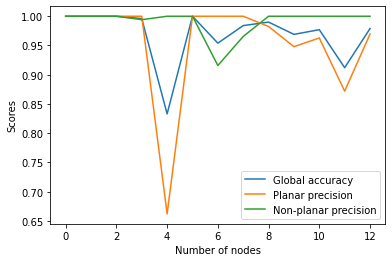

[(1.0, 1, 1),
 (1.0, 1, 1),
 (1.0, 1.0, 1.0),
 (0.996, 1.0, 0.9941262848751835),
 (0.833, 0.6619433198380567, 1.0),
 (1.0, 1.0, 1.0),
 (0.954, 1.0, 0.9157509157509157),
 (0.984, 1.0, 0.9654427645788337),
 (0.99, 0.9824561403508771, 1.0),
 (0.969, 0.947986577181208, 1.0),
 (0.977, 0.9627831715210357, 1.0),
 (0.912, 0.8719068413391557, 1.0),
 (0.979, 0.969521044992743, 1.0)]

In [18]:
from qplanarity import test_suite_dgl

train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'

test_suite_dgl(train_ns, train_nbs, generator, seed=21)